PENGUMPULAN DATA

In [ ]:
#install library
print("Menginstal pustaka 'google-play-scraper' dan 'pandas'...")
!pip install google-play-scraper pandas

#import library yang dipakai
import pandas as pd                              # buat ngolah data tabel
from google_play_scraper import Sort, reviews   # buat ambil review dari Google Play
from google.colab import files                  # buat download file dari Colab
import datetime                                 # buat ngatur dan bandingkan tanggal

 # ambil review dari Google Play, filter pakai rentang tanggal, balikin dalam bentuk DataFrame.
def scrape_reviews_filtered(app_id, app_name, start_date, end_date, total_count=20000):

    all_reviews_data = []   # penampung review yg kepake (udah lolos filter tanggal)
    count = 0               # hitung total review yg udah diambil sejauh ini
    next_token = None       # token buat lanjut ke halaman review berikutnya

    while count < total_count:
        try:
            # ambil batch review dari Play Store
            result, next_token = reviews(
                app_id,            # id aplikasi di Play Store
                lang='id',         # pake bahasa Indonesia
                country='id',      # region Indonesia
                sort=Sort.NEWEST,  # urutkan dari review terbaru
                count=200,         # sekali ambil maksimal 200 review
                continuation_token=next_token
            )
        except Exception as e:
            # kalau error pas scraping
            print(f"Error saat mengambil data: {e}. Menghentikan scraping.")
            break

        # kalau result kosong, berarti udah ga ada review lagi
        if not result:
            break

        # loop tiap review yg baru diambil
        for r in result:
            tanggal = r.get('at')
            if tanggal:
                tanggal = tanggal.date()


                if start_date <= tanggal <= end_date:
                    all_reviews_data.append({
                        'userName': r.get('userName'),   # nama user
                        'review': r.get('content'),      # isi ulasan
                        'at': r.get('at'),               # tanggal & waktu ulasan
                        'score': r.get('score'),         # rating
                        'app_name': app_name             # nama aplikasinya
                    })

                elif tanggal < start_date:
                    return pd.DataFrame(all_reviews_data)

        # update total review yg udah diambil
        count += len(result)

        # kalau sudah tdk ada next_token, berarti halaman review habis
        if not next_token:
            break

    #ubah list review jadi DataFrame utk diolah
    return pd.DataFrame(all_reviews_data)

def main():
    # set rentang tanggal penelitian
    start_date = datetime.date(2025, 6, 1)
    end_date = datetime.date(2025, 8, 31)

    # ambil review BRImo
    print("Scraping BRImo (Juni - Agustus 2025)...")
    df_brimo = scrape_reviews_filtered(
        'id.co.bri.brimo',   # app_id
        'BRImo',             # nama aplikasi
        start_date,
        end_date
    )
    print(f"BRImo selesai. Ditemukan {len(df_brimo)} ulasan.")

    # ambil review BCA Mobile
    print("\nScraping BCA Mobile (Juni - Agustus 2025)...")
    df_bca = scrape_reviews_filtered(
        'com.bca',          # app_id
        'BCA Mobile',       # nama aplikasi
        start_date,
        end_date
    )
    print(f"BCA Mobile selesai. Ditemukan {len(df_bca)} ulasan.")

    # gabungin data BRImo dan BCA Mobile jadi satu DataFrame
    df_all = pd.concat([df_brimo, df_bca], ignore_index=True)

    # data yg berhasil diambil
    if not df_all.empty:
        filename = "hasil_ulasan_juni-agustus.csv"
        df_all.to_csv(filename, index=False, encoding="utf-8-sig")

        print(f"\nScraping dan filter selesai. File '{filename}' siap diunduh.")
        try:
            files.download(filename)  # download file
        except Exception as e:
            print(f"Gagal mengunduh file: {e}. File tetap tersimpan di environment Colab.")

    else:
        print("Tidak ada ulasan ditemukan dalam periode Juni - Agustus 2025.")

# titik awal program, kalau file ini dijalankan, langsung lari ke main()
if __name__ == "__main__":
    main()


Menginstal pustaka 'google-play-scraper' dan 'pandas'...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
Scraping BRImo (Juni - Agustus 2025)...
BRImo selesai. Ditemukan 0 ulasan.

Scraping BCA Mobile (Juni - Agustus 2025)...
BCA Mobile selesai. Ditemukan 4587 ulasan.

Scraping dan filter selesai. File 'hasil_ulasan_juni-agustus.csv' siap diunduh.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PRAPROSES DATA

cleansing

In [ ]:
# install pustaka
print("Menginstal pustaka 'pandas'...")
!pip install pandas

# import pustaka
import pandas as pd
import re
from google.colab import files

def cleansing(text):
    # bersihin teks ulasan
    # kalau datanya kosong, balik ke string kosong
    if pd.isna(text):
        return ""
    # hapus angka, tanda baca, dan simbol, sisain huruf dan spasi
    return re.sub(r'[^a-zA-Z\s]', '', str(text), re.I | re.A)

def main():
    # nama file hasil scraping
    input_file = "hasil_ulasan_juni-agustus.csv"

    try:
        # baca file ke dataframe
        df = pd.read_csv(input_file)

        # cek dulu, kolom 'review'
        if 'review' not in df.columns:
            print("kolom 'review' tidak ketemu, cek lagi struktur file input.")
            return

        # buang baris yang review nya kosong
        df.dropna(subset=['review'], inplace=True)

        # jalanin fungsi cleansing ke tiap review
        print("\nMulai proses cleansing teks ulasan...")
        df['cleansing'] = df['review'].apply(cleansing)

        # simpan hasil cleansing ke file baru
        output_file = "1_cleansing.csv"
        df.to_csv(output_file, index=False, encoding="utf-8-sig")

        print(f"Cleansing Selesai! File '{output_file}' siap diunduh.")
        files.download(output_file)

    except FileNotFoundError:
        # kalau file belum ada / namanya beda
        print(f"file '{input_file}' n Tidak ditemukan. Pastikan sudah ada hasil scraping sebelumnyaa.")

# titik awal program
if __name__ == "__main__":
    main()


Menginstal pustaka 'pandas'...

Mulai proses cleansing teks ulasan...
Cleansing Selesai! File '1_cleansing.csv' siap diunduh.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

case folding

In [ ]:
def case_folding(text):
    # ubah teks jadi huruf kecil semua
    return str(text).lower()

def main():
    # pakai file hasil cleansing
    input_file = "1_cleansing.csv"

    try:
        # baca file ke dataframe
        df = pd.read_csv(input_file)

        # pastikan kolom 'cleansing' ada
        if 'cleansing' not in df.columns:
            print("kolom 'cleansing' tidak ketemu, cek lagi file input.")
            return

        # jalanin case folding ke tiap teks di kolom cleansing
        print("\nMulai proses case folding...")
        df['case_folding'] = df['cleansing'].apply(case_folding)

        # simpan hasil ke file baru
        output_file = "2_case_folding.csv"
        df.to_csv(output_file, index=False, encoding="utf-8-sig")

        print(f"Case folding selesai! File '{output_file}' siap diunduh.")
        files.download(output_file)

    except FileNotFoundError:
        # kalau file 1_cleansing.csv belum ada / namanya beda
        print(f"file '{input_file}' tidak ditemukan. Jalankan dulu tahap cleansing.")

# titik awal program
if __name__ == "__main__":
    main()


Mulai proses case folding...
Case folding selesai! File '2_case_folding.csv' siap diunduh.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

tokenizing

In [ ]:
def tokenizing(text):
    # ubah unit unit kata
    return str(text).split()

def main():
    # input dari tahap sebelumnya
    input_file = "2_case_folding.csv"

    try:
        # baca file ke dataframe
        df = pd.read_csv(input_file)

        # pastikan kolom 'case_folding' ada
        if 'case_folding' not in df.columns:
            print("kolom 'case_folding' tidak ditemukan, cek lagi file input.")
            return

        # jalanin tokenizing ke tiap teks di kolom case_folding
        print("\nMulai proses tokenizing...")
        df['tokenizing'] = df['case_folding'].apply(tokenizing)

        # simpan hasil ke file baru
        output_file = "3_tokenizing.csv"
        df.to_csv(output_file, index=False, encoding="utf-8-sig")

        print(f"Tokenizing selesai! File '{output_file}' siap diunduh.")
        files.download(output_file)

    except FileNotFoundError:
        # kalau file 2_case_folding.csv belum ada / namanya beda
        print(f"file '{input_file}' tidak ditemukan. jalankan dulu tahap case folding.")

# titik awal program
if __name__ == "__main__":
    main()



Mulai proses tokenizing...
Tokenizing selesai! File '3_tokenizing.csv' siap diunduh.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

normalization

In [ ]:
# kamus kata tidak baku jadi baku
normalisasi_dict = {
    "bgt": "banget", "bgttttt": "banget", "bangettt": "banget",
    "yg": "yang", "yng": "yang",
    "g": "tidak", "ga": "tidak", "gak": "tidak", "gk": "tidak", "tdk": "tidak", "nggak": "tidak",
    "tp": "tapi", "tpi": "tapi",
    "dgn": "dengan", "dg": "dengan",
    "ok": "oke", "oke": "oke", "okey": "oke",
    "pake": "pakai", "pkai": "pakai",
    "bnran": "benaran", "bnr": "benar",
    "syg": "sayang",
    "sm": "sama", "smua": "semua",
    "udh": "sudah", "udah": "sudah", "sdh": "sudah",
    "blm": "belum", "belom": "belum",
    "krn": "karena", "karna": "karena",
    "trs": "terus", "trus": "terus",
    "aja": "saja", "aj": "saja",
    "jg": "juga"
}

def normalization(tokens):
    # ubah unit kata tidak baku jadi baku pakai kamus
    tokens = eval(tokens)
    return [normalisasi_dict.get(token, token) for token in tokens]

def main():
    # input dari tahap sebelumnya (hasil tokenizing)
    input_file = "3_tokenizing.csv"

    try:
        # baca file ke dataframe
        df = pd.read_csv(input_file)

        # pastikan kolom 'tokenizing' ada
        if 'tokenizing' not in df.columns:
            print("kolom 'tokenizing' tidak ditemukan, cek lagi file input.")
            return

        # jalanin normalization ke tiap baris di kolom tokenizing
        print("\nMulai proses normalization...")
        df['normalization'] = df['tokenizing'].apply(normalization)

        # simpan hasil ke file baru
        output_file = "4_normalization.csv"
        df.to_csv(output_file, index=False, encoding="utf-8-sig")

        print(f"Normalization selesai! File '{output_file}' siap diunduh.")
        files.download(output_file)

    except FileNotFoundError:
        # kalau file 3_tokenizing.csv belum ada / namanya beda
        print(f"file '{input_file}' tidak ditemukan. jalankan dulu tahap tokenizing.")

# titik awal program
if __name__ == "__main__":
    main()



Mulai proses normalization...
Normalization selesai! File '4_normalization.csv' siap diunduh.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

filtering

In [ ]:
# install pustaka
print("Menginstal pustaka 'pandas' dan 'Sastrawi'...")
!pip install pandas Sastrawi

# import pustaka
import pandas as pd
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from google.colab import files

# objek penghapus stopword bawaan Sastrawi :pakai kamus kata umum bhs indo
factory_stopword = StopWordRemoverFactory()
stopword = factory_stopword.create_stop_word_remover()

def filtering(tokens):
    # dari string -> list
    tokens = eval(tokens)
    # list -> kalimat
    text = " ".join(tokens)
    # hapus kata-kata umum yang kurang penting makna
    return stopword.remove(text)

def main():
    # input dari tahap sebelumnya
    input_file = "4_normalization.csv"

    try:
        # baca file ke dataframe
        df = pd.read_csv(input_file)

        # pastikan kolom 'normalization' ada
        if 'normalization' not in df.columns:
            print("kolom 'normalization' tidak ditemukan, cek lagi file input.")
            return

        # jalanin filtering ke tiap baris
        print("\nMulai proses filtering (stopword removal)...")
        df['filtering'] = df['normalization'].apply(filtering)

        # simpan hasil ke file baru
        output_file = "5_filtering.csv"
        df.to_csv(output_file, index=False, encoding="utf-8-sig")

        print(f"Filtering selesai! File '{output_file}' siap diunduh.")
        files.download(output_file)

    except FileNotFoundError:
        # kalau file 4_normalization.csv belum ada / namanya beda
        print(f"file '{input_file}' tidak ditemukan. jalankan dulu tahap normalization.")

# titik awal program
if __name__ == "__main__":
    main()


Menginstal pustaka 'pandas' dan 'Sastrawi'...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.0 MB/s eta 0:00:00

Mulai proses filtering (stopword removal)...
Filtering selesai! File '5_filtering.csv' siap diunduh.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

stemming

In [ ]:
# import pustaka
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google.colab import files

# buat objek stemmer dari Sastrawi
factory_stemmer = StemmerFactory()
stemmer = factory_stemmer.create_stemmer()

def stemming(text):
    # ubah kata-kata ke bentuk dasar (stemming bahasa Indonesia)
    return stemmer.stem(str(text))

def main():
    # input dari tahap sebelumnya
    input_file = "5_filtering.csv"

    try:
        # baca file ke dataframe
        df = pd.read_csv(input_file)

        # pastikan kolom 'filtering' ada
        if 'filtering' not in df.columns:
            print("kolom 'filtering' tidak ditemukan, cek lagi file input.")
            return

        # jalanin stemming ke tiap baris di kolom filtering
        print("\nMulai proses stemming...")
        df['stemming'] = df['filtering'].apply(stemming)

        # simpan hasil ke file baru
        output_file = "6_stemming.csv"
        df.to_csv(output_file, index=False, encoding="utf-8-sig")

        print(f"Stemming selesai! File '{output_file}' siap diunduh.")
        files.download(output_file)

    except FileNotFoundError:
        # kalau file 5_filtering.csv belum ada / namanya beda
        print(f"file '{input_file}' tidak ditemukan. jalankan dulu tahap filtering.")

# titik awal program
if __name__ == "__main__":
    main()



Mulai proses stemming...
Stemming selesai! File '6_stemming.csv' siap diunduh.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PELABELAN

revisi pelabelan positif negatif

In [ ]:
# install pustaka
print("Menginstal pustaka 'pandas' dan 'Sastrawi'...")
!pip install -q pandas Sastrawi

# import pustaka
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# helper untuk colab biar tidak error kalau bukan di colab
try:
    from google.colab import files
    _IN_COLAB = True
except Exception:
    _IN_COLAB = False

# kamus kata positif
positive_words = [
    "bagus","mantap","mudah","cepat","suka","puas","baik","keren","oke","top",
    "lancar","praktis","nyaman","terbaik","senang","mantul","recommended","helpful",
    "bantu","guna","andalan","canggih","stabil","terpercaya","simple","aman","mudahguna",
    "update","responsif","friendly","ramah","ringan","berkembang","bermanfaat","bisa",
    "solusi","hebat","sukses","worth","kualitas","inovatif","support","berguna",
    "rekomendasi","informatif","gampang","puji", "membantu","memudahkan","mempermudah","memuaskan","good",
    "bertransaksi","terimakasih"
]

# kamus kata negatif
negative_words = [
    "error","lemot","buruk","susah","jelek","lama","gagal","kecewa","parah",
    "ribet","crash","hang","lag","mengecewakan","payah","macet","lelet","bengong",
    "lemotsekali","ngelag","bug","tidakbisa","ganggu","gangguan","hilang","masalah",
    "eror","berhenti","pusing","tidakjalan","sulit","redup","lemotparah","gagaltransaksi",
    "hancur","ngeloadlama","tidakresponsif","susahakses","trouble","kacau","jatuh",
    "sampah","bikinpusing","menyusahkan","lambat","hilangdata","lemotbanget",
    "tidakberfungsi","gagalupdate", "down","tutup","gabisa","aneh","force"
]

# buat objek stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def do_stemming(text: str) -> str:
    # kalau kosong, kasih tanda "-"
    if pd.isna(text) or str(text).strip() == "":
        return "-"
    # stemming + lower
    return stemmer.stem(str(text).lower())

# fungsi hitung skor sentimen + label
def score_and_label(text: str):
    if pd.isna(text) or str(text).strip() == "":
        return 0, "netral"

    # ubah teks ke bentuk string dan huruf kecil semua
    t = str(text).lower()
    # token sederhana (pisah spasi, buang koma/titik)
    tokens = set(t.replace(",", " ").replace(".", " ").split())

    # hitung kemunculan kata positif/negatif
    pos_count = sum(w in tokens or w in t for w in positive_words)
    neg_count = sum(w in tokens or w in t for w in negative_words)

    skor = pos_count - neg_count
    if skor > 0:
        label = "positif"
    elif skor < 0:
        label = "negatif"
    else:
        label = "netral"
    return skor, label

# evaluasi ulang yang netral
def refine_neutral(row):
    """
    kalau label awal 'netral', pakai rating 'score' untuk tentukan condong ke mana.
      - score >= 4        -> positif (skor = 1)
      - 0 < score <= 2    -> negatif (skor = -1)
      - score 3 atau 0    -> tetap netral (skor apa adanya)
    """
    skor = row["skor_sentimen"]
    label = row["label"]
    rating = row.get("score", 0)

    # kalau sudah positif/negatif, tidak diubah
    if label != "netral":
        return skor, label

    # coba ubah rating ke angka
    try:
        rating = float(rating)
    except Exception:
        # kalau rating tidak jelas, biarkan netral
        return skor, label

    if rating >= 4:
        return 1, "positif"
    elif rating <= 2 and rating > 0:
        return -1, "negatif"
    else:
        # rating 3 atau 0 -> tetap netral
        return skor, label


def main():
    input_file = "6_stemming.csv"
    output_file = "revisi_pelabelan_lexicon_skor_netral.csv"

    try:
        df = pd.read_csv(input_file)

        # pastikan kolom minimal ada, kalau tidak ada isi default
        if "userName" not in df.columns and "username" in df.columns:
            df.rename(columns={"username": "userName"}, inplace=True)
        if "userName" not in df.columns:
            df["userName"] = "user_tidak_ada"
        if "review" not in df.columns:
            df["review"] = "-"
        if "at" not in df.columns:
            df["at"] = "0000-00-00"
        if "score" not in df.columns:
            df["score"] = 0
        if "app_name" not in df.columns:
            df["app_name"] = "unknown"

        # stemming berdasarkan kolom review
        df["stemming"] = df["review"].apply(do_stemming)

        # 1. hitung skor dan label sentimen dari lexikon
        hasil = df["stemming"].apply(score_and_label)
        df["skor_sentimen"] = hasil.apply(lambda x: x[0])
        df["label"] = hasil.apply(lambda x: x[1])

        # 2. khusus baris yang netral, revisi pakai rating 'score'
        df[["skor_sentimen", "label"]] = df.apply(
            lambda r: pd.Series(refine_neutral(r)),
            axis=1
        )

        # atur urutan kolom akhir
        final_cols = ["userName", "review", "at", "score", "app_name", "stemming", "skor_sentimen", "label"]
        df_final = df[final_cols].copy()

        # simpan hasil
        df_final.to_csv(output_file, index=False, encoding="utf-8-sig")
        print("Berhasil membuat file:", output_file)
        print(df_final.head(10))

        if _IN_COLAB:
            files.download(output_file)

    except FileNotFoundError:
        print(f"File '{input_file}' tidak ditemukan. Pastikan tahap sebelumnya sudah dijalankan.")

if __name__ == "__main__":
    main()


Menginstal pustaka 'pandas' dan 'Sastrawi'...
Berhasil membuat file: revisi_pelabelan_lexicon_skor_netral.csv
           userName                                             review  \
0       Abdul Munir                                                 ok   
1       Indra Dollu                                sangat membantu ❤❤😍   
2      Karyanto Tel                                        sangat puas   
3       Restu Sukma               setelah di update jadi susah buat tf   
4         Ulil Azmi                                             mantap   
5          Nyong 24                                    sangat membantu   
6       Rasya Wahyu  tingkat kan terus aplikasi nya dan berikan kem...   
7   Novia Wulandari  Aplikasi yg bagus . memudahkan costumer dlm be...   
8  Andri Agus piana                                              bagus   
9     Yopi Hermawan                       ribet, urusan y bertele tele   

                    at  score app_name  \
0  2025-08-31 23:58:15      5    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PELATIHAN NAIVE BAYES & EVALUASI MODEL

Model & vectorizer disimpan sebagai nb_vectorizer.pkl dan nb_model.pkl


=== CLASSIFICATION REPORT - BRImo ===
              precision    recall  f1-score   support

     negatif       0.73      0.73      0.73       346
     positif       0.96      0.96      0.96      2242

    accuracy                           0.93      2588
   macro avg       0.84      0.84      0.84      2588
weighted avg       0.93      0.93      0.93      2588



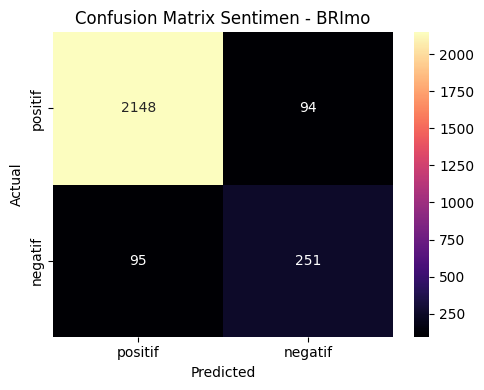



=== CLASSIFICATION REPORT - BCA Mobile ===
              precision    recall  f1-score   support

     negatif       0.75      0.84      0.79       324
     positif       0.91      0.85      0.88       604

    accuracy                           0.84       928
   macro avg       0.83      0.84      0.83       928
weighted avg       0.85      0.84      0.85       928



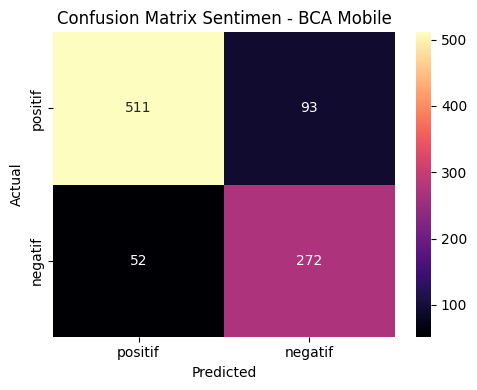

In [ ]:
# TRAINING NAIVE BAYES SENTIMEN

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
import joblib  # untuk simpan model

# 1. LOAD DATA
df = pd.read_csv("revisi_pelabelan_lexicon_skor_netral.csv")

# dua aplikasi yang diteliti
df = df[df["app_name"].isin(["BRImo", "BCA Mobile"])]

# hanya label positif dan negatif
df = df[df["label"].isin(["positif", "negatif"])].copy()

# --- BERSIHKAN NaN DI STIMMING ---
df["stemming"] = df["stemming"].fillna("")
# buang baris yang stemming-nya kosong betul
df = df[df["stemming"].str.strip() != ""].copy()

# reset index supaya indexing iloc aman (0..n-1)
df = df.reset_index(drop=True)

# X = fitur teks (hasil stemming), y = label sentimen
X = df["stemming"].astype(str)
y = df["label"]

# 2. TF–IDF
# ubah teks menjadi vektor angka menggunakan TF-IDF
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    sublinear_tf=True
)
X_vec = vectorizer.fit_transform(X)

# 3. SPLIT
# bagi data jadi 80% train, 20% test, stratify=y supaya proporsi label tetap seimbang
# X_train  -> fitur data latih, X_test -> fitur data uji,
# y_train  -> label data latih, y_test -> label data uji
X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y,
    test_size=0.2,# 20% TEST, 80% TRAIN
    random_state=42,
    stratify=y )

# 4. TRAIN NAIVE BAYES
model = MultinomialNB()
model.fit(X_train, y_train)

# 5. PREDIKSI & AKURASI
y_pred = model.predict(X_test)

# 6. SIMPAN MODEL & VECTORIZER UNTUK STREAMLIT
joblib.dump(vectorizer, "nb_vectorizer.pkl")
joblib.dump(model, "nb_model.pkl")
print("Model & vectorizer disimpan sebagai nb_vectorizer.pkl dan nb_model.pkl")

# 7. BUAT TABEL HASIL PREDIKSI PER APLIKASI
hasil = pd.DataFrame({
    "app_name": df.iloc[y_test.index]["app_name"],
    "actual": y_test.values,
    "predicted": y_pred
})

def show_report_and_heatmap(df_app, app_name):
    if df_app.empty:
        print(f"\nTidak ada data uji untuk {app_name}, report dan heatmap tidak dibuat.")
        return

    # tampilkan classification_report
    print(f"\n\n=== CLASSIFICATION REPORT - {app_name} ===")
    print(classification_report(df_app["actual"], df_app["predicted"]))


    # buat confusion matrix sederhana (aktual dan prediksi)
    cm = pd.crosstab(df_app["actual"], df_app["predicted"])
    cm = cm.reindex(index=["positif", "negatif"],
                    columns=["positif", "negatif"],
                    fill_value=0)

    # plot heatmap dari confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="magma", cbar=True)
    plt.title(f"Confusion Matrix Sentimen - {app_name}", fontsize=12)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

df_brimo = hasil[hasil["app_name"] == "BRImo"]
df_bca   = hasil[hasil["app_name"] == "BCA Mobile"]

show_report_and_heatmap(df_brimo, "BRImo")
show_report_and_heatmap(df_bca, "BCA Mobile")


In [15]:
#  CROSS VALIDATION MODEL NAIVE BAYES

import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Load Dataset
print(" Membaca dataset...")
df = pd.read_csv("revisi_pelabelan_lexicon_skor_netral.csv")

# Validasi data
df = df[df["stemming"].notna() & df["label"].notna()]
df = df[df["label"].isin(["positif", "negatif"])]

# data per aplikasi
df_brimo = df[df["app_name"] == "BRImo"].reset_index(drop=True)
df_bca   = df[df["app_name"] == "BCA Mobile"].reset_index(drop=True)

print("Jumlah data BRImo :", len(df_brimo))
print("Jumlah data BCA   :", len(df_bca))

# Fungsi Cross Validation
def cross_validation_nb(df_app, nama_app):
    print(f"\nCROSS VALIDATION : {nama_app}")

    vectorizer = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        sublinear_tf=Truea
    )

    X = vectorizer.fit_transform(df_app["stemming"])
    y = df_app["label"]

    model = MultinomialNB()

    skf = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    )

    cv_scores = cross_val_score(
        model,
        X,
        y,
        cv=skf,
        scoring="accuracy"
    )

    # Tampilkan hasil
    for i, score in enumerate(cv_scores, start=1):
        print(f"Fold {i} Accuracy : {round(score * 100, 2)}%")

    print("Rata-rata Akurasi :", round(cv_scores.mean() * 100, 2), "%")
    print("Standar Deviasi   :", round(cv_scores.std() * 100, 2), "%")

    return cv_scores

# jalankan Cross Validation
cv_brimo = cross_validation_nb(df_brimo, "BRImo")
cv_bca   = cross_validation_nb(df_bca, "BCA Mobile")

print("\nCross Validation selesai!")


 Membaca dataset...
Jumlah data BRImo : 13066
Jumlah data BCA   : 4510

CROSS VALIDATION : BRImo
Fold 1 Accuracy : 91.93%
Fold 2 Accuracy : 91.66%
Fold 3 Accuracy : 92.04%
Fold 4 Accuracy : 91.47%
Fold 5 Accuracy : 91.89%
Rata-rata Akurasi : 91.8 %
Standar Deviasi   : 0.21 %

CROSS VALIDATION : BCA Mobile
Fold 1 Accuracy : 86.59%
Fold 2 Accuracy : 88.58%
Fold 3 Accuracy : 87.36%
Fold 4 Accuracy : 86.92%
Fold 5 Accuracy : 87.03%
Rata-rata Akurasi : 87.29 %
Standar Deviasi   : 0.69 %

Cross Validation selesai!


In [ ]:
!ls


6_stemming.csv	   pelabelan_lexicon_skor_netral.csv
nb_model.pkl	   revisi_pelabelan_lexicon_skor_netral.csv
nb_vectorizer.pkl  sample_data


In [ ]:
from google.colab import files

files.download("nb_vectorizer.pkl")
files.download("nb_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

VISUALISASI

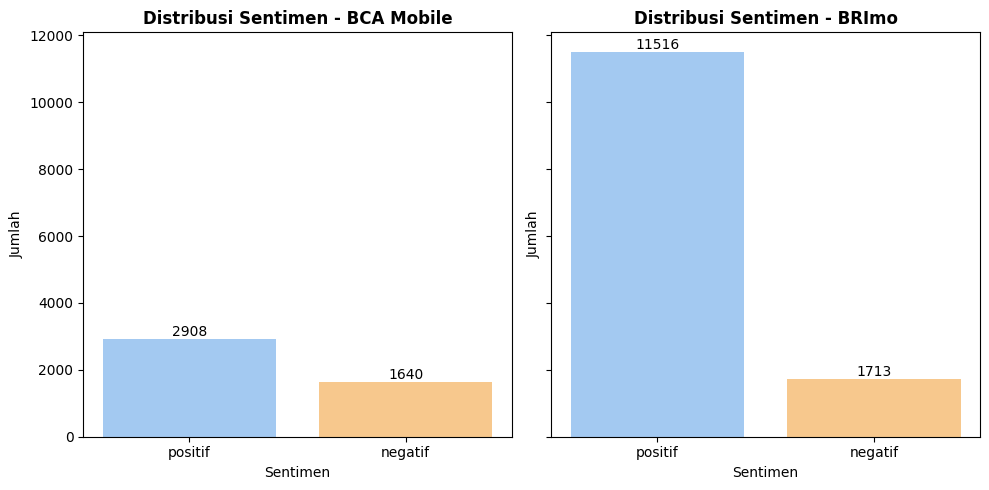

In [ ]:
# VISUALISASI DISTRIBUSI SENTIMEN: BCA Mobile dan BRImo

import pandas as pd
import matplotlib.pyplot as plt

# 1) baca data dari file hasil pelabelan leksikon
df = pd.read_csv("revisi_pelabelan_lexicon_skor_netral.csv")

# rapikan isi kolom label: buang spasi dan samakan jadi huruf kecil
df["label"] = df["label"].astype(str).str.strip().str.lower()

# 2) pilih hanya dua aplikasi yang mau dibandingkan
apps = ["BCA Mobile", "BRImo"]
df = df[df["app_name"].isin(apps)]

# 3) urutan label sentimen yang mau dipakai di sumbu x
sentiment_order = ["positif", "negatif"]

# 4) buat 2 subplot berdampingan (1 baris, 2 kolom), sharey=True biar sumbu Y sama
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# warna pastel: indeks 0 untuk positif, indeks 1 untuk negatif
colors = ["#A3C9F1", "#F7C88D"]

# looping untuk tiap aplikasi dan subplot
for ax, app in zip(axes, apps):
    # filter data untuk satu aplikasi, hitung jumlah per label,
    # reindex pakai sentiment_order supaya urutan batang konsisten
    counts = (
        df[df["app_name"] == app]["label"]
        .value_counts()  # di sini python otomatis hitung total 'positif' & 'negatif'
        .reindex(sentiment_order)
        .fillna(0)
        .astype(int)
    )

    # gambar bar chart dengan warna sesuai urutan label
    bars = ax.bar(sentiment_order, counts.values, color=colors)

    # judul dan label sumbu
    ax.set_title(f"Distribusi Sentimen - {app}", fontsize=12, fontweight="bold")
    ax.set_xlabel("Sentimen")
    ax.set_ylabel("Jumlah")

    # tampilkan angka di atas masing-masing batang
    ax.bar_label(bars, fmt="%d", fontsize=10)

# rapikan layout
plt.tight_layout()
plt.show()


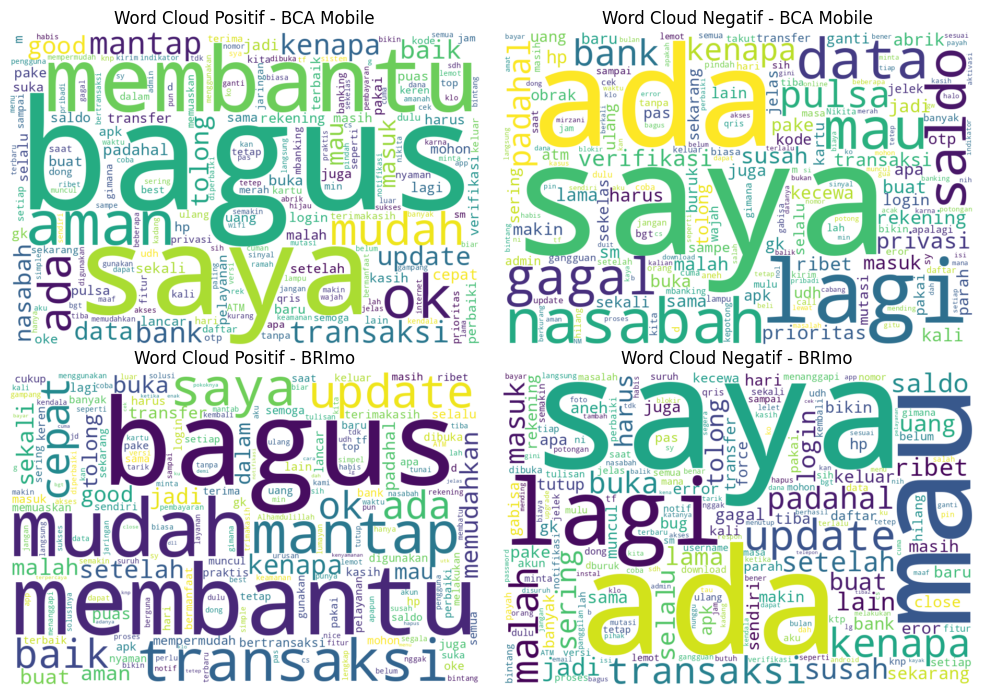

In [ ]:
# WORD CLOUD SENTIMEN: BCA Mobile & BRImo

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# 1) Baca data dari file hasil pelabelan leksikon
df = pd.read_csv("revisi_pelabelan_lexicon_skor_netral.csv")

# 2) rapikan label dan batasi ke dua aplikasi penelitian
df["label"] = df["label"].astype(str).str.strip().str.lower()  # buang spasi & samakan huruf kecil
apps = ["BCA Mobile", "BRImo"]                                 # aplikasi yang mau dianalisis
df = df[df["app_name"].isin(apps)]                             # filter hanya dua aplikasi ini

# 3) Tentukan kolom teks yang dipakai untuk word cloud
# daftar kemungkinan nama kolom teks (biar script agak fleksibel)
text_candidates = [
    "clean_text", "text_clean", "processed_text",
    "text", "tweet", "review", "content", "komentar"
]
# ambil nama kolom pertama yang ketemu di dataframe
text_col = next((c for c in text_candidates if c in df.columns), None)
if text_col is None:
    # kalau tidak ada satupun, hentikan proses dan kasih pesan jelas
    raise ValueError(
        f"Tidak menemukan kolom teks. Pastikan salah satu dari {text_candidates} ada di CSV."
    )

# 4) Siapkan stopwords (gabungan bawaan wordcloud + stopword Indonesia versi sendiri)
stop_id = {
    "yang","dan","di","ke","dari","untuk","pada","tidak","ini","itu","ya","nya",
    "kok","ga","gak","guna","agar","kalo","kalau","aja","saja","bisa","udah",
    "sudah","dengan","karena","lebih","atau","tp","tapi","banget","sangat",
    "yg","dr","krn","trus","terus",
    # buang nama bank/aplikasi supaya word cloud fokus ke kata isi
    "bca","bri","brimo","mobile","aplikasi","aplikasinya"
}
# stopwords akhir = stopword inggris bawaan + stopword indonesia buatan sendiri
stopwords = STOPWORDS.union(stop_id)

# 5) Fungsi untuk bikin 1 word cloud (satu kombinasi app + sentimen)
def plot_wordcloud(dataframe, app, sentimen, ax, title):
    # filter data sesuai nama aplikasi dan label sentimen
    mask = (dataframe["app_name"] == app) & (dataframe["label"] == sentimen)
    # gabungkan semua teks jadi satu string panjang
    corpus = " ".join(dataframe.loc[mask, text_col].astype(str))

    # kalau tidak ada teks (misal datanya kosong), tulis info di kotaknya
    if not corpus.strip():
        ax.text(0.5, 0.5, "Tidak ada teks", ha="center", va="center", fontsize=12)
        ax.axis("off")
        ax.set_title(title)
        return

    # buat objek word cloud dari teks gabungan
    wc = WordCloud(
        width=900,
        height=600,
        background_color="white",
        stopwords=stopwords,
        max_words=200,
        collocations=False,
        normalize_plurals=True
    ).generate(corpus)   # di sini WordCloud:
                          #    - baca semua teks di 'corpus'
                          #    - hitung berapa kali tiap kata muncul
                          #    - makin sering muncul -> ukuran kata di gambar makin besar

    # tampilkan gambar word cloud di subplot yang dikasih (ax)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(title)

# 6) Siapkan kanvas 2x2: baris 1 BCA, baris 2 BRImo, kiri positif, kanan negatif
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

# BCA Mobile: positif & negatif
plot_wordcloud(df, "BCA Mobile", "positif", axes[0, 0], "Word Cloud Positif - BCA Mobile")
plot_wordcloud(df, "BCA Mobile", "negatif", axes[0, 1], "Word Cloud Negatif - BCA Mobile")

# BRImo: positif & negatif
plot_wordcloud(df, "BRImo", "positif", axes[1, 0], "Word Cloud Positif - BRImo")
plot_wordcloud(df, "BRImo", "negatif", axes[1, 1], "Word Cloud Negatif - BRImo")

# rapikan layout biar tidak saling tindih
plt.tight_layout()
plt.show()
